In [35]:
import os.path
import json
from collections import defaultdict

import newsbreaker
from newsbreaker.data import load_entries

from pymongo import MongoClient

import autograd.numpy as np
from autograd import grad

import pandas as pd
%matplotlib inline

from sklearn import cross_validation

# Initialization

In [2]:
folder = os.path.join('..', 'data')

In [3]:
newsbreaker.init(os.path.join(folder, 'topic_model'), 'topic_model.pkl', 'vocab.txt')

In [4]:
entries = load_entries(folder)

In [5]:
entries_dict = defaultdict(list)

for entry in entries:
    entries_dict[entry.feed].append(entry)

In [6]:
client = MongoClient()
db = client.newstagger

# Algorithm

In [7]:
def get_entry(s):
    feedname, index = s.split('|')
    try:
        index = int(index)
    except ValueError:
        raise KeyError('Malformed entry %s' % s)
    
    for feed, l in entries_dict.items():
        if feed.name == feedname:
            for entry in l:
                if entry.index == index:
                    return entry
            else:
                break
    
    raise KeyError('Entry %s not found' % s)

In [ ]:
coefs = []
Y = []
tests = list(db.pairs.find())

for test in tests:
    base = get_entry(test['base'])
    e1 = get_entry(test['e1'])
    e2 = get_entry(test['e2'])
    
    coefs.append(
        [
            [
                base.what_distance(e1),
                base.who_distance(e1),
                base.where_distance(e1)
            ],
            [
                base.what_distance(e2),
                base.who_distance(e2),
                base.where_distance(e2)
            ]
        ]
    )
    
    Y.append(float(test['res']))

Save coefs (X) and Y, along with tests (to know what each row refers to) to work with it later

In [18]:
with open('X.txt', 'w') as f:
    f.write('\n'.join(str(x) for x in coefs))

In [19]:
with open('Y.txt', 'w') as f:
    f.write('\n'.join(str(x) for x in Y))

In [15]:
import json

with open('tests.json', 'w') as f:
    f.write(
        json.dumps(
            [
                { k: v for k, v in d.items() if k != '_id' }
                for d in tests
            ], 
            indent=2
        )
    )

# What without NEs

In [38]:
from collections import Counter

def what_without_ne(entry):
    entry.doc(tag=True, parse=False, entity=True)
    
    avoid_ent_cats = set(entry.who_ne_cats)
    avoid_ent_cats.update(entry.where_ne_cats)
    
    avoid_ents = [
        (ent.start, ent.end)
        for ent in entry.doc.ents
        if ent.label_ in avoid_ent_cats
    ]
    
    words = []
    doc_words = list(entry.doc)
    
    while doc_words and avoid_ents:
        i = doc_words[0].i
            
        low, high = avoid_ents[0]
        
        if i < low:
            words.append(doc_words.pop(0))
        elif low <= i and i < high:
            doc_words.pop(0) # but don't save it, since is part of NE
        else: # low < high <= i
            avoid_ents.pop(0) # delete ent, since we overpassed it
            
    words += doc_words # no more ents to filter with
    
    counter = Counter(
        word.lower_
        for word in words
    )
    
    entry._what = entry.topic_model.model.transform(
        np.array([ counter[word] for word in entry.topic_model.vocab ])
    )

In [ ]:
not_ne_what_coefs = []

for test in tests:
    base = get_entry(test['base'])
    what_without_ne(base)
    
    e1 = get_entry(test['e1'])
    what_without_ne(e1)
    
    e2 = get_entry(test['e2'])
    what_without_ne(e2)
    
    not_ne_what_coefs.append(
        [
            base.what_distance(e1),
            base.what_distance(e2)
        ]
    )

# SGD

In [16]:
with open('X.txt') as f:
    coefs = [eval(x) for x in f.read().split('\n')]

In [17]:
with open('Y.txt') as f:
    Y = [float(x) for x in f.read().split('\n')]

In [36]:
with open('tests.json') as f:
    tests = json.loads(f.read())

In [40]:
X_copy = list(coefs); Y_copy = list(Y)

In [41]:
X = np.array(
    [
        [
            v1[i] - v2[i]
            for i in range(3)
        ]
        
        for v1, v2 in coefs
    ]
)

Y = np.array(Y)

In [42]:
X_not_ne_what = np.array(
    [
        [
            not_ne_what_coefs[n][0] - not_ne_what_coefs[n][1],
            row[1], row[2]
        ]
        
        for n, row in enumerate(X)
    ]
)

In [43]:
def sigmoid(x, gamma=1.):
    return 1.0 / (1.0 + np.exp(-gamma * x))

In [44]:
def cost(theta, X=None, Y=None): # theta is np.array    
    return np.sum(
        (sigmoid(np.dot(X, np.abs(theta))) - Y) ** 2
    ) / len(X)

In [45]:
grad_cost = grad(cost)

In [46]:
class SGD:
    
    def __init__(self, learning=0.5, max_iters=10**5, prec=10**-3):
        self.learning = learning
        self.max_iters = max_iters
        self.prec = prec
        
        self.theta = None
        
        self._iters = None
        self._costs = None
        
        
    def get_params(self, deep=True):
        return {
            'learning': self.learning,
            'max_iters': self.max_iters,
            'prec': self.prec
        }
    
    
    @property
    def iters(self):
        if self._iters is None:
            raise Exception('SGD must be fitted to access iters')
        
        return self._iters
    
    @iters.setter
    def iters(self, value): self._iters = value
        
        
    @property
    def costs(self):
        if self._costs is None:
            raise Exception('SGD must be fitted to access costs')
        
        return self._costs
    
    @costs.setter
    def costs(self, value): self._costs = value
        
    
    def fit(self, X, Y):
        self.iters = 0
        self.costs = []
        theta = np.random.random(3)
    
        while self.iters < self.max_iters: 
            self.iters += 1
            self.costs.append(cost(theta, X=X, Y=Y))
            
            prev_theta = theta.copy()
            theta -= self.learning * grad_cost(theta, X=X, Y=Y)

            if np.linalg.norm(theta - prev_theta) < self.prec:
                break
        
        self.costs.append(cost(theta, X=X, Y=Y))
        self.theta = theta
        return self
    
    
    def score(self, X, Y):
        return sum(
            (not ((pred > 0.) ^ (cls > 0.))) if pred != 0. else 0.
            for pred, cls in zip(np.dot(X, self.theta), Y)
        ) / len(Y)

In [47]:
class WhatSGD(SGD):
    
    def fit(self, X, Y):
        self.theta = np.array([1., 0., 0.])
        return self

## Simple trial

In [48]:
threshold = int(len(X) * 0.9)
X_train, X_test = X[:threshold], X[threshold:]
Y_train, Y_test = Y[:threshold], Y[threshold:]

In [49]:
trained_sgd = SGD()
trained_sgd.fit(X_train, Y_train)

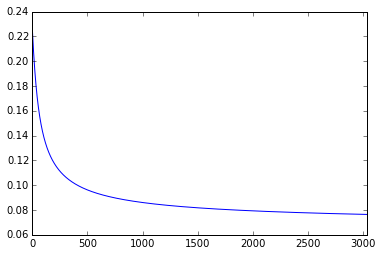

In [50]:
pd.Series(trained_sgd.costs).plot() # error on each iteration

# Run cross validation for each model

In [51]:
X_not_what = X.copy()

for row in X_not_what:
    row[0] = 0

In [52]:
sgd = SGD()
what_sgd = WhatSGD()
sgd_not_what = SGD()

In [53]:
rows = []

for i in range(2, 20 + 1):
    rows.append(
        [
            cross_validation.cross_val_score(
                sgd, X, Y, cv=i
            ), 
            cross_validation.cross_val_score(
                sgd, X_not_ne_what, Y, cv=i
            ), 
            cross_validation.cross_val_score(
                what_sgd, X, Y, cv=i
            ),
            cross_validation.cross_val_score(
                what_sgd, X_not_ne_what, Y, cv=i
            )
        ]
    )
    
for n, i in enumerate(range(2, 20 + 1)):
    rows[n].append(
        cross_validation.cross_val_score(
            sgd_not_what, X_not_what, Y, cv=i
        )
    )

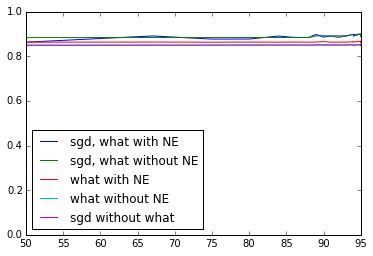

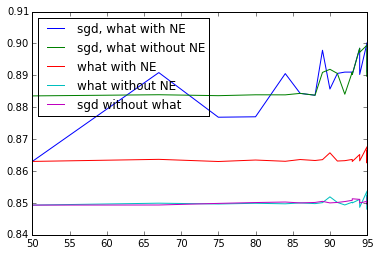

In [54]:
df = pd.DataFrame(
    [[s.mean() for s in row] for row in rows],
    columns=['sgd, what with NE', 'sgd, what without NE', 'what with NE', 'what without NE', 'sgd without what'],
    index=[100 - 100 // i for i in range(2, 20 + 1)]
)

df.plot(ylim=(0, 1))
df.plot()

In [118]:
df.mean()

sgd, what with NE       0.888554
sgd, what without NE    0.889896
what with NE            0.863847
what without NE         0.850207
dtype: float64

In [119]:
df[df.index > 75].mean()

sgd, what with NE       0.890741
sgd, what without NE    0.891056
what with NE            0.863964
what without NE         0.850315
dtype: float64

In [121]:
df[df.index > 90].mean()

sgd, what with NE       0.893258
sgd, what without NE    0.893134
what with NE            0.864073
what without NE         0.850366
dtype: float64

# Scores of each model

In [104]:
scores = cross_validation.cross_val_score(
    sgd, X, Y, cv=10
)

scores, scores.mean()

(array([ 0.93333333,  0.73333333,  0.93333333,  0.86666667,  0.93333333,
         0.6       ,  1.        ,  0.85714286,  1.        ,  1.        ]),
 0.88571428571428579)

In [105]:
scores = cross_validation.cross_val_score(
    sgd, X_not_ne_what, Y, cv=10
)

scores, scores.mean()

(array([ 0.93333333,  0.73333333,  0.93333333,  0.93333333,  0.93333333,
         0.66666667,  1.        ,  0.78571429,  1.        ,  1.        ]),
 0.89190476190476198)

In [106]:
scores = cross_validation.cross_val_score(
    what_sgd, X, Y, cv=10
)

scores, scores.mean()

(array([ 0.86666667,  0.73333333,  1.        ,  0.86666667,  0.8       ,
         0.53333333,  1.        ,  0.92857143,  1.        ,  0.92857143]),
 0.86571428571428566)

In [107]:
scores = cross_validation.cross_val_score(
    what_sgd, X_not_ne_what, Y, cv=10
)

scores, scores.mean()

(array([ 0.93333333,  0.6       ,  0.93333333,  0.86666667,  0.8       ,
         0.6       ,  1.        ,  0.85714286,  1.        ,  0.92857143]),
 0.85190476190476194)

In [31]:
sgd_not_what = SGD()
scores = cross_validation.cross_val_score(
    sgd_not_what, X_not_what, Y, cv=10
)

scores, scores.mean()

(array([ 0.86666667,  0.6       ,  0.93333333,  0.73333333,  0.93333333,
         0.93333333,  0.92857143,  0.71428571,  0.92857143,  0.92857143]),
 0.84999999999999998)

# Final results

In [122]:
sgd = SGD()
sgd.fit(X, Y)

In [35]:
cost(sgd.theta, X, Y), cost(sgd.theta / sgd.theta.sum(), X, Y)

(0.071000318084466746, 0.21243174195639319)

The one not normalised gets less error due to the fact that bigger absolute values make sigmoid closer to 1 or 0, thus reducing the error. Anyhow, the desired value is the one normalised (values must sum 1)

In [123]:
sgd.theta, sgd.theta / sgd.theta.sum()

(array([ 6.22461219,  5.57323577,  5.22079321]),
 array([ 0.3657526 ,  0.32747831,  0.3067691 ]))

In [125]:
sgd = SGD()
sgd.fit(X_not_ne_what, Y)

In [126]:
sgd.theta, sgd.theta / sgd.theta.sum()

(array([ 6.23380888,  5.47779867,  4.87390334]),
 array([ 0.37585872,  0.33027615,  0.29386513]))

Notice how with not-ne-what What becomes slightly more important (maybe because it doesn't lose accuracy due to NE mistreatment?). Even if the resulting accuracy is the same but more stable, the other system makes What be more easily computed in terms of performance, so it would still be the selected approach, because the algorithm is slow enough already. In next steps, when the algorithm is optimised, working with not-ne-what would be a good idea.

Finally, by checking what would be the values with just Who and Where:

In [64]:
sgd_not_what = SGD()
sgd_not_what.fit(X_not_what, Y)

(sgd_not_what.theta - np.array([sgd_not_what.theta[0], 0., 0.])) / sgd_not_what.theta[1:].sum()

array([ 0.        ,  0.61922324,  0.38077676])

Who is really the most important of the two, almost twice